# Hw5 (parallel bifurcation and spectrogram)

Mirpulatov Islombek

PHD-1, CDSE

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## 1. Implement parallel version of bifurcation map (2 point)

In [2]:
%%writefile bifurcation.py

from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt


def logistic_map(x, rate):
    return rate * x * (1 - x)


def biffurication_map(x_0, R, N, M):
    rate = []
    population = []

    for r in R:
        x = x_0
        for i in range(0, N):
            x = logistic_map(x, r)
        for i in range(0, M):
            x = logistic_map(x, r)
            population.append(x)
            rate.append(r)
    return population, rate


def main():
    len_r = 1000
    N = 400
    M = 400
    r = np.linspace(0, 4, len_r)
    x_0 = np.random.rand()


    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()

    r_chunk = np.array_split(r, size)[rank]

    population_chunk, rate_chunk = biffurication_map(x_0, r_chunk, N, M)

    rate = comm.gather(rate_chunk, root=0)
    population = comm.gather(population_chunk, root=0)

    if rank == 0:
        rate = np.hstack(rate)
        population = np.hstack(population)

        plt.figure(figsize=(14, 7))
        plt.scatter(rate, population, s=0.5)
        plt.xlabel('Rate')
        plt.ylabel('Population')
        plt.grid()
        plt.savefig('bifurcation.png')


if __name__ == '__main__':
    main()

Overwriting bifurcation.py


In [3]:
! mpirun -n 4 python bifurcation.py

Check that bifurcation is working

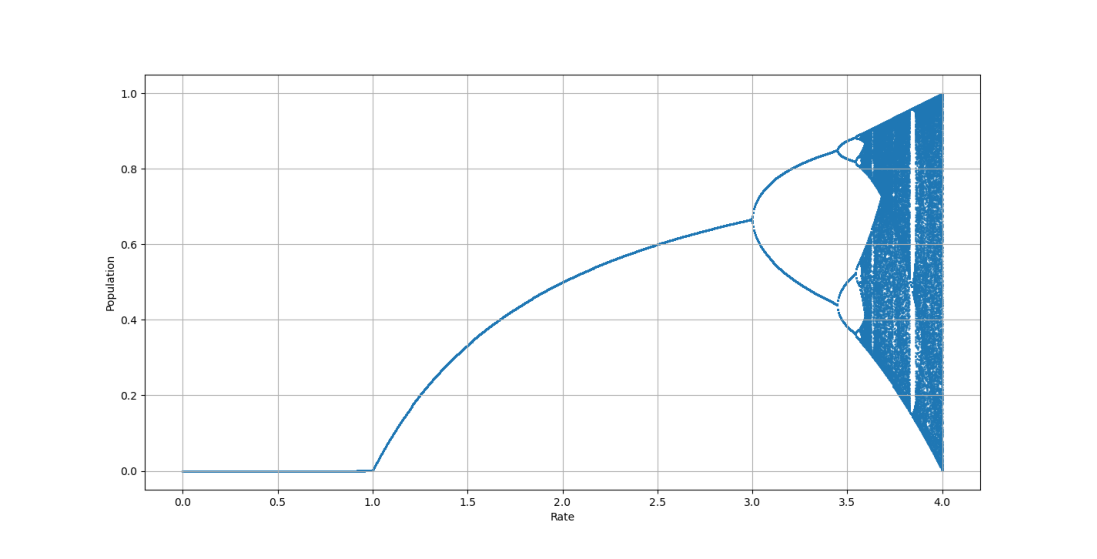

In [4]:
img = mpimg.imread('bifurcation.png')
plt.figure(figsize=(14, 7))
plt.imshow(img)
plt.axis('off')
plt.show()

## 2. Plot speedup vs. number of processes/threads (2 points)

In [5]:
%%writefile bifurcation.py

from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt


def logistic_map(x, rate):
    return rate * x * (1 - x)


def biffurication_map(x_0, R, N, M):
    rate = []
    population = []

    for r in R:
        x = x_0
        for i in range(0, N):
            x = logistic_map(x, r)
        for i in range(0, M):
            x = logistic_map(x, r)
            population.append(x)
            rate.append(r)
    return population, rate


def main():
    len_r = 5000
    N = 400
    M = 400
    r = np.linspace(0, 4, len_r)
    x_0 = np.random.rand()


    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()

    r_chunk = np.array_split(r, size)[rank]

    if rank == 0:
      start_time = MPI.Wtime()

    population_chunk, rate_chunk = biffurication_map(x_0, r_chunk, N, M)

    if rank == 0:
      end_time = MPI.Wtime()
      t = end_time - start_time
      print("Size: ", size, "\tTime elapsed: ", np.round(t, 3))

    rate = comm.gather(rate_chunk, root=0)
    population = comm.gather(population_chunk, root=0)

    if rank == 0:
        rate = np.hstack(rate)
        population = np.hstack(population)


if __name__ == '__main__':
    main()


Overwriting bifurcation.py


In [6]:
for i in range(1, 5):
    ! mpirun -n {i} python bifurcation.py

Size:  1 	Time elapsed:  0.803
Size:  2 	Time elapsed:  0.399
Size:  3 	Time elapsed:  0.274
Size:  4 	Time elapsed:  0.223


In [17]:
time = np.array([0.803, 0.407, 0.274, 0.223])
size = np.array([1, 2, 3, 4])

In [18]:
speedup = 0.803 / time

In [19]:
speedup

array([1.        , 1.97297297, 2.93065693, 3.60089686])

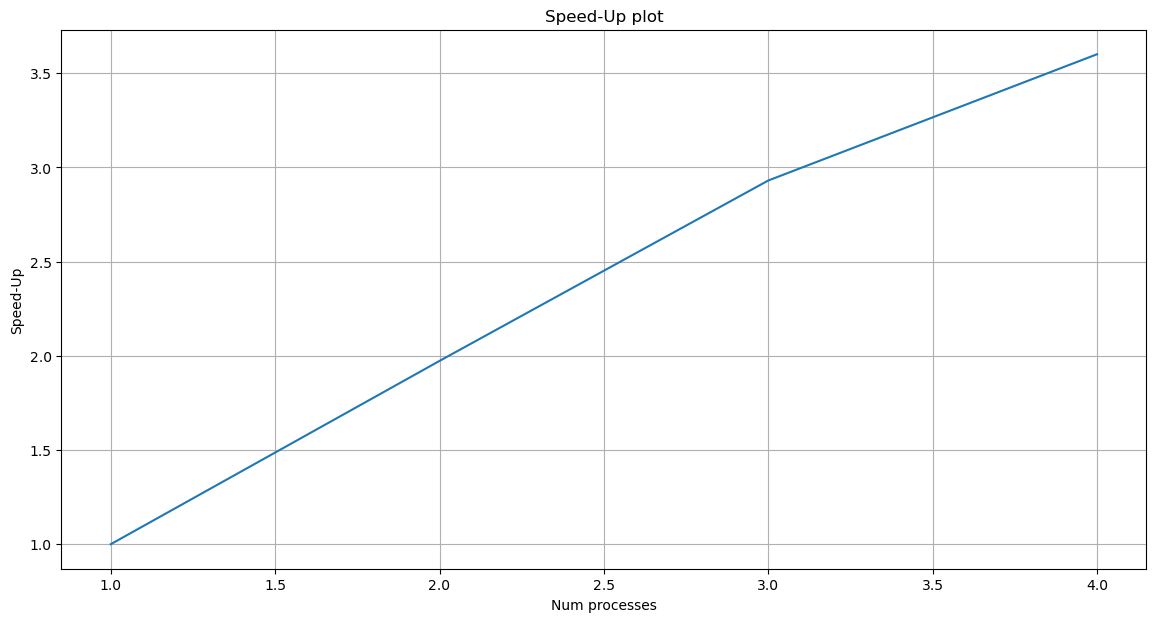

In [20]:
plt.figure(figsize=(14, 7))
plt.plot(size, speedup)
plt.title("Speed-Up plot")
plt.ylabel('Speed-Up')
plt.xlabel('Num processes')
plt.grid()
plt.show()

## 3. Implement parallel version of spectrogram (2 points)

In [6]:
%%writefile spectrogram.py

from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt

def create_wave(t):
    y = 13 * np.sin(1.5 * t) * np.exp(-(t - 6 * 3.5 * np.pi)**2/2/20**2)
    y += 7 * np.sin(3.3 * t) * np.exp(-(t - 4 * 3* np.pi)**2/2/20**2)
    y += 5 * np.sin(4.13 * t) * np.exp(-(t - 13 * np.pi)**2/2/20**2)
    y += 17 * np.sin(t) * np.exp(-(t - np.pi)**2/2/20**2)
    return y

def get_specgram(t, y, start_pos, stop_pos, nwindowsteps=10000):
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()

    window_positions = np.linspace(start_pos, stop_pos, nwindowsteps)
    wp_chunk = np.array_split(window_positions, size)[rank]

    window_width = 2.0*2*np.pi

    specgram_chunk = np.empty([len(t), len(wp_chunk)])

    for i, window_position in enumerate(wp_chunk):
        y_window = y * np.exp(- (t - window_position) ** 2 / 2 / window_width ** 2)
        specgram_chunk[:, i] = np.abs(np.fft.fft(y_window))

    specgram = comm.gather(specgram_chunk, root=0)

    if rank == 0:
        return np.concatenate(specgram, axis=1)

def plot_spectrogram(sp):
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_ylim(0, 10)
    spec = ax.imshow(sp, aspect='auto', cmap='plasma', extent=[-20, 20, 0, 350])
    fig.colorbar(spec, ax=ax, label='Intensity')
    plt.title("Spectrogram")
    ax.set_xlabel('T, cycles')
    ax.set_ylabel('Frequency, arb. units')
    plt.savefig('spectrogram.png')
    plt.show()

def main():
    t = np.linspace(-20 * 2 * np.pi, 20 * 2 * np.pi, 2**13)
    y = create_wave(t)
    spectogram = get_specgram(t, y, -20 * 2 * np.pi, 20 * 2 * np.pi, nwindowsteps=10000)

    if MPI.COMM_WORLD.Get_rank() == 0:
        plot_spectrogram(spectogram)

if __name__ == '__main__':
    main()


Overwriting spectrogram.py


In [8]:
! mpirun -n 4 python spectrogram.py

Figure(1000x800)


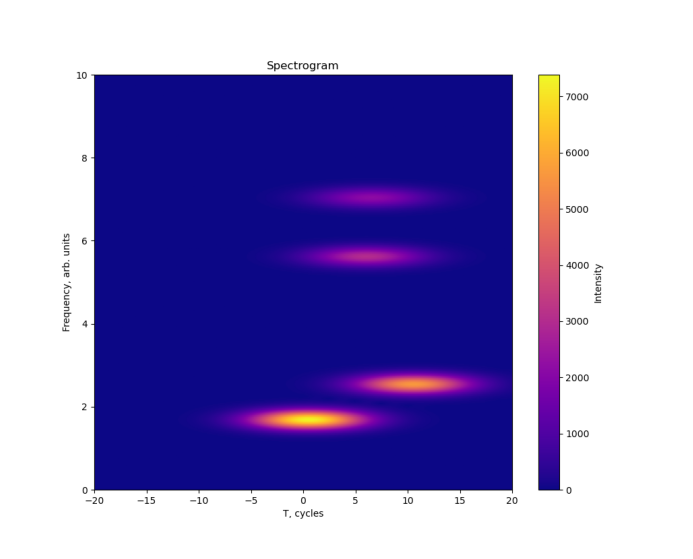

In [11]:
img = mpimg.imread('spectrogram.png')
plt.figure(figsize=(14, 7))
plt.imshow(img)
plt.axis('off')
plt.show()

## 4. Plot speedup vs. number of processes/threads (2 points)

In [8]:
%%writefile spectrogram.py

from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt

def create_wave(t):
    y = 13 * np.sin(1.5 * t) * np.exp(-(t - 6 * 3.5 * np.pi)**2/2/20**2)
    y += 7 * np.sin(3.3 * t) * np.exp(-(t - 4 * 3* np.pi)**2/2/20**2)
    y += 5 * np.sin(4.13 * t) * np.exp(-(t - 13 * np.pi)**2/2/20**2)
    y += 17 * np.sin(t) * np.exp(-(t - np.pi)**2/2/20**2)
    return y

def get_specgram(t, y, start_pos, stop_pos, nwindowsteps=10000):
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()

    window_positions = np.linspace(start_pos, stop_pos, nwindowsteps)

    start_time = MPI.Wtime()
    wp_chunk = np.array_split(window_positions, size)[rank]

    window_width = 2.0*2*np.pi

    specgram_chunk = np.empty([len(t), len(wp_chunk)])

    for i, window_position in enumerate(wp_chunk):
        y_window = y * np.exp(- (t - window_position) ** 2 / 2 / window_width ** 2)
        specgram_chunk[:, i] = np.abs(np.fft.fft(y_window))

    specgram = comm.gather(specgram_chunk, root=0)

    if rank == 0:
        cn = np.concatenate(specgram, axis=1)
        end_time = MPI.Wtime()
        t = end_time - start_time
        print("Size: ", size, "\tTime elapsed: ", np.round(t, 3))
        return cn

def main():
    t = np.linspace(-20 * 2 * np.pi, 20 * 2 * np.pi, 2**12)
    y = create_wave(t)
    spectogram = get_specgram(t, y, -20 * 2 * np.pi, 20 * 2 * np.pi, nwindowsteps=10000)

if __name__ == '__main__':
    main()


Overwriting spectrogram.py


In [9]:
for i in range(1, 5):
    ! mpirun -n {i} python spectrogram.py

Size:  1 	Time elapsed:  1.597
Size:  2 	Time elapsed:  1.06
Size:  3 	Time elapsed:  0.915
Size:  4 	Time elapsed:  0.909


In [12]:
time = np.array([1.597, 1.06, 0.915, 0.909])
size = np.array([1, 2, 3, 4])

In [13]:
speedup = 1.597 / time

In [15]:
speedup

array([1.        , 1.50660377, 1.74535519, 1.75687569])

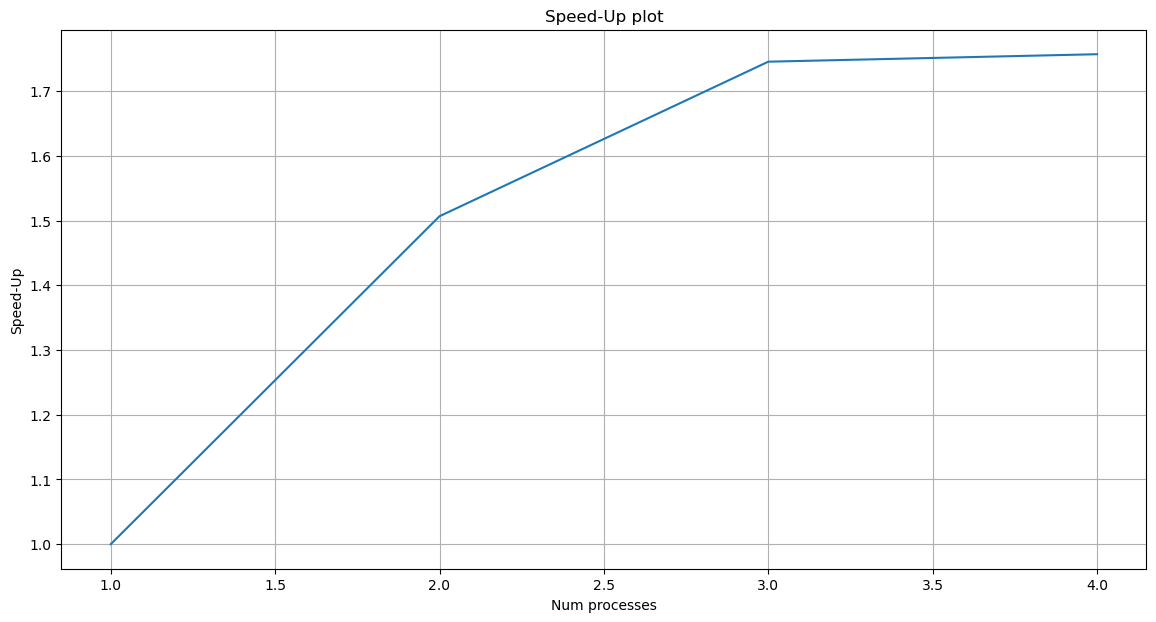

In [16]:
plt.figure(figsize=(14, 7))
plt.plot(size, speedup)
plt.title("Speed-Up plot")
plt.ylabel('Speed-Up')
plt.xlabel('Num processes')
plt.grid()
plt.show()